In [2]:
import pandas as pd
from transformers import DistilBertTokenizerFast, BertForTokenClassification
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
from wordcloud import WordCloud

In [3]:
data = '../data/articles.csv'
df = pd.read_csv(data)

In [4]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

filtered_df = df[(df['date'].dt.year == 2015) & (df['date'].dt.month <= 3) & (df['category'].str.lower() == 'mercado')]

In [5]:
checkpoint = 'monilouise/ner_pt_br'
tokenizer = DistilBertTokenizerFast.from_pretrained(checkpoint)
model = BertForTokenClassification.from_pretrained(checkpoint)     

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizerFast'.
Some weights of the model checkpoint at monilouise/ner_pt_br were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraini

In [6]:
ner_pipeline = pipeline('ner', model=model, tokenizer=tokenizer)

In [7]:
def extract_organizations(text):
    entities = ner_pipeline(text)
    organizations = []
    current_entity = []
    for entity in entities:
        if 'entity_group' in entity and entity['entity_group'] == 'ORG':
            current_entity.append(entity['word'])
        elif 'entity' in entity and entity['entity'] == 'B-ORG':
            if current_entity:
                organizations.append(" ".join(current_entity).replace(" ##", ""))
                current_entity = []
            current_entity.append(entity['word'])
        elif 'entity' in entity and entity['entity'] == 'I-ORG' and current_entity:
            current_entity.append(entity['word'])
        elif current_entity:
            organizations.append(" ".join(current_entity).replace(" ##", ""))
            current_entity = []
    if current_entity:
        organizations.append(" ".join(current_entity).replace(" ##", ""))
    return organizations

In [8]:
all_organizations = []
for article in tqdm(filtered_df['text'], desc="Processando artigos"):
    all_organizations.extend(extract_organizations(article))
    
organization_counts = Counter(all_organizations)

Processando artigos:   0%|          | 0/2111 [00:00<?, ?it/s]

In [9]:
ranking = organization_counts.most_common()
ranking_df = pd.DataFrame(ranking, columns=['Organization', 'Count'])
ranking_df

,Organization,Count
0,Folha,511
1,O,256
2,Sete,105
3,Brad,98
4,B,93
...,...,...
1736,Austin,1
1737,Economist Intelligence,1
1738,Greater Miami Convention and Visitors,1
1739,Standart,1


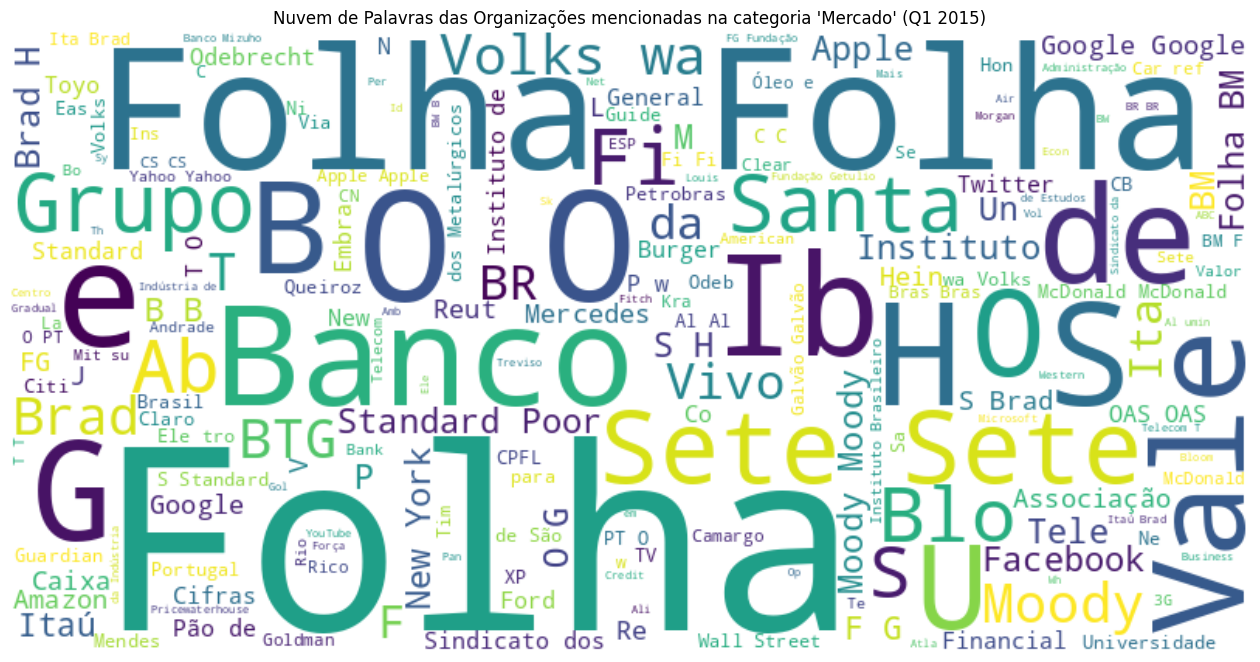

In [13]:
organization_string = " ".join(all_organizations)

def plot_wordcloud(text, ax):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    return ax

fig, ax = plt.subplots(figsize=(16, 12))
plot_wordcloud(organization_string, ax)
ax.set_title("Nuvem de Palavras das Organizações mencionadas na categoria 'Mercado' (Q1 2015)")
plt.show()